# Creating Volcano Maps with Pandas and the Matplotlib Basemap Toolkit

**Author**: [Ramiro Gómez](http://ramiro.org/)

## Introduction

This notebook walks through the process of creating maps of volcanoes with Python. The main steps involve getting, cleaning and finally mapping the data.

All Python 3rd party packages used, except the [Matplotlib Basemap Toolkit](http://matplotlib.org/basemap/), are included with the [Anaconda distribution](https://store.continuum.io/cshop/anaconda/) and installed when you create an anaconda environment. To add Basemap simply run the command `conda install basemap` in your activated anaconda environment. To follow the code you should be familiar with [Python](https://www.python.org/), [Pandas](http://pandas.pydata.org/) and [Matplotlib](http://matplotlib.org/).

## Get into work

First load all Python libraries required in this notebook.

In [1]:
%load_ext signature
%matplotlib inline

import json

from lxml import html
from mpl_toolkits.basemap import Basemap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

chartinfo = 'Author: Ramiro Gómez - ramiro.org | Data: Volcano World - volcano.oregonstate.edu'

## Get the volcano data

The data is downloaded and parsed using lxml. The [Volcano World source page](http://volcano.oregonstate.edu/oldroot/volcanoes/alpha.html) lists the volcano data in several HTML tables, which are each read into individual Pandas data frames that are appended to a list of data frames. Since the page also uses tables for layout the first four tables are omitted.

In [2]:
url ='http://volcano.oregonstate.edu/oldroot/volcanoes/alpha.html'
xpath = '//table'
tree = html.parse(url)
tables = tree.xpath(xpath)

table_dfs = []
for idx in range(4, len(tables)):
    df = pd.read_html(html.tostring(tables[idx]), header=0)[0]
    table_dfs.append(df)

The next step is to create a single data frame from the ones in the list using Pandas' `concat` method. To create a new index with consecutive numbers the `index_ignore` parameter is set to `True`.

In [3]:
df_volc = pd.concat(table_dfs, ignore_index=True)

Let's take a look at the data contained in the newly created data frame.

In [4]:
print(len(df_volc))
df_volc.head(10)

1560


,Name,Location,Type,Latitude,Longitude,Elevation (m)
0,Abu,Honshu-Japan,Shield volcanoes,34.50,131.60,641
1,Acamarachi,Chile-N,Stratovolcano,-23.30,-67.62,6046
2,Acatenango,Guatemala,Stratovolcano,14.50,-90.88,3976
3,Acigöl-Nevsehir,Turkey,Caldera,38.57,34.52,1689
4,Adams,US-Washington,Stratovolcano,46.21,-121.49,3742
5,Adams Seamount,Pacific-C,Submarine volcano,-25.37,-129.27,-39
6,Adatara,Honshu-Japan,Stratovolcanoes,37.64,140.29,1718
7,Adwa,Ethiopia,Stratovolcano,10.07,40.84,1733
8,Afderà,Ethiopia,Stratovolcano,13.08,40.85,1295
9,Agrigan,Mariana Is-C Pacific,Stratovolcano,18.77,145.67,965


The data frame contains 1560 records with information on name, location, type, latitude, longitude and elevation. Let's first examine the different types.

In [5]:
df_volc['Type'].value_counts()

Stratovolcano           601
Shield volcano          121
Stratovolcanoes         109
Submarine volcano        95
Volcanic field           82
Caldera                  78
Cinder cones             62
Complex volcano          49
Shield volcanoes         31
Pyroclastic cones        30
Lava domes               26
Submarine volcano ?      19
Volcanic  field          16
Fissure vents            16
Shield  volcano          16
Submarine  volcano       16
Maars                    12
Compound volcano         10
Cinder  cones            10
Lava dome                 9
Cinder cone               9
Calderas                  9
Pyroclastic cone          8
Tuff cones                7
Scoria cones              7
Maar                      7
Unknown                   6
Complex  volcano          6
Somma volcano             5
Lava  domes               5
                       ... 
Subglacial  volcano       2
Lava cone                 2
Explosion craters         2
Fissure vent              2
Fissure  vents      

Looking at the output we see that a single type may be represented by diffent tokens, for example Stratvolcano and Stratvolcanoes refer to the same type. Sometimes entries contain question marks, indicating that the classification may not be correct.

## Cleaning the data

The next step is to clean the data. I decided to take the classification for granted and simply remove question marks. Also, use one token for each type and change the alternative spellings accordingly. Finally remove superfluous whitespace and start all words with capital letter.

In [6]:
def cleanup_type(s):
    if not isinstance(s, str):
        return s
    s = s.replace('?', '').replace('  ', ' ')
    s = s.replace('volcanoes', 'volcano')
    s = s.replace('volcanoe', 'Volcano')
    s = s.replace('cones', 'cone')
    s = s.replace('Calderas', 'Caldera')
    return s.strip().title()

df_volc['Type'] = df_volc['Type'].map(cleanup_type)
df_volc['Type'].value_counts()

Stratovolcano         713
Shield Volcano        173
Submarine Volcano     137
Volcanic Field         98
Caldera                87
Cinder Cone            84
Complex Volcano        56
Pyroclastic Cone       43
Lava Domes             31
Fissure Vents          18
Tuff Cone              14
Maars                  12
Compound Volcano       11
Lava Dome              10
Scoria Cone             8
Pyroclastic Shield      8
Maar                    7
Unknown                 6
Somma Volcano           6
Subglacial Volcano      6
Crater Rows             5
Lava Cone               5
Fumarole Field          3
Pumice Cone             3
Explosion Craters       2
Volcanic Complex        2
Fissure Vent            2
Flood Basalt            1
Cones                   1
Hydrothermal Field      1
Island Arc              1
Cone                    1
Volcanic Landform       1
Lava Field              1
Tuff Rings              1
Flood Basalts           1
dtype: int64

Now let's get rid of incomplete records.

In [7]:
df_volc.dropna(inplace=True)
len(df_volc)

1513

## Creating the maps

Volcanoes will be plotted as red triangles, whose sizes depend on the elevation values, that's why I'll only consider positive elevations, i. e. remove submarine volcanoes from the data frame.

In [8]:
df_volc = df_volc[df_volc['Elevation (m)'] >= 0]
len(df_volc)

1406

Next I define a function that will plot a volcano map for the given parameters. Lists of longitudes, latitudes and elevations, that all need to have the same lengths, are mandatory, the other parameters have defaults set.

As mentioned above, sizes correspond to elevations, i. e. a higher volcano will be plotted as a larger triangle. To achieve this the 1st line in the `plot_map` function creates an array of bins and the 2nd line maps the individual elevation values to these bins.

Next a Basemap object is created, coastlines and boundaries will be drawn and continents filled in the given color. Then the volcanoes are plotted. The 3rd parameter of the `plot` method is set to `^r`, the circumflex stands for triangle and r for red. For more details, see the [documentation for plot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot).

The Basemap object will be returned so it can be manipulated after the function finishes and before the map is plotted, you'll see why in a later example.

In [9]:
def plot_map(lons, lats, elevations, projection='mill', llcrnrlat=-80, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='i', min_marker_size=2):
    bins = np.linspace(0, elevations.max(), 10)
    marker_sizes = np.digitize(elevations, bins) + min_marker_size

    m = Basemap(projection=projection, llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, resolution=resolution)
    m.drawcoastlines()
    m.drawmapboundary()
    m.fillcontinents(color = '#333333')
    
    for lon, lat, msize in zip(lons, lats, marker_sizes):
        x, y = m(lon, lat)
        m.plot(x, y, '^r', markersize=msize, alpha=.7)
    
    return m

### Map of Stratovolcanos

The 1st map shows the locations of Stratovolcanoes on a world map, so the data frame is filtered on the type column beforehand.

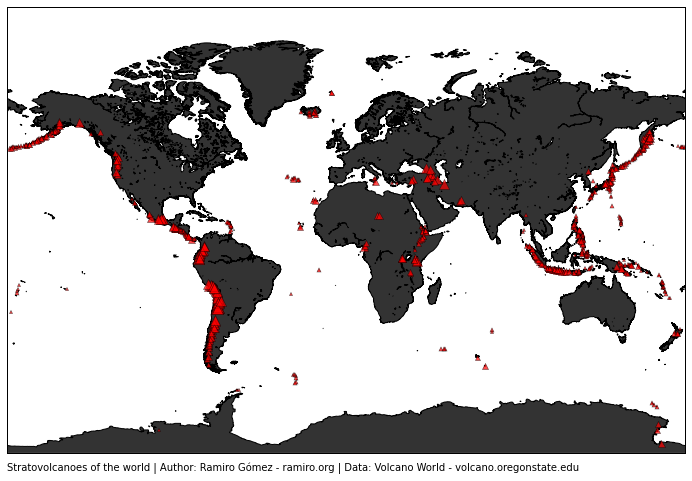

In [10]:
plt.figure(figsize=(16, 8))
df = df_volc[df_volc['Type'] == 'Stratovolcano']
plot_map(df['Longitude'], df['Latitude'], df['Elevation (m)'])
plt.annotate('Stratovolcanoes of the world | ' + chartinfo, xy=(0, -1.04), xycoords='axes fraction')

We can clearly see that most Stratovolcanoes are located, where tectonic plates meet. Let's look at all volcanoes of some of those regions now.

## Volcanoes of North America

The next map shows all North American volcanoes in the data frame. To display only that part of the map the parameters that determine the bounding box are set accordingly, i. e. the latitudes and longitudes of the lower left and upper right corners of the bounding box.

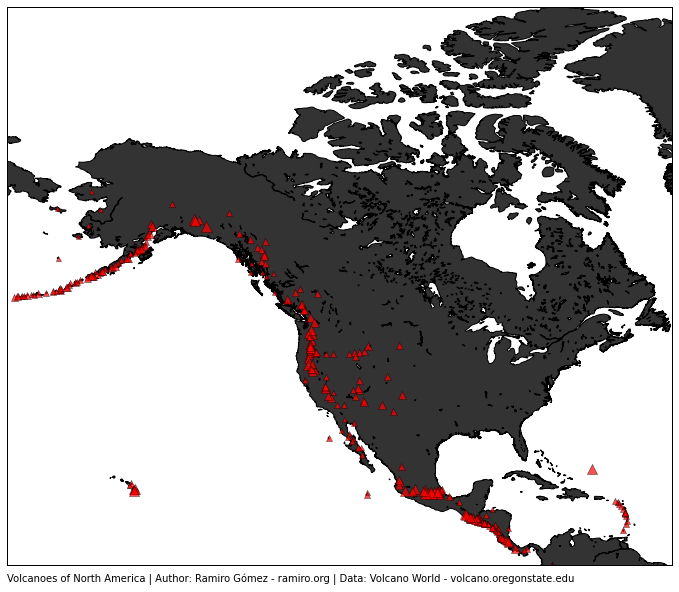

In [11]:
plt.figure(figsize=(12, 10))
plot_map(df_volc['Longitude'], df_volc['Latitude'], df_volc['Elevation (m)'],
         llcrnrlat=5.5, urcrnrlat=83.2, llcrnrlon=-180, urcrnrlon=-52.3, min_marker_size=4)
plt.annotate('Volcanoes of North America | ' + chartinfo, xy=(0, -1.03), xycoords='axes fraction')

## Volcanoes of Indonesia

Another region with many volcanoes is the Indonesian archipelago. Some of them like the Krakatoa and Mount Tambora have undergone catastrophic eruptions with [tens of thousands of victims](https://en.wikipedia.org/wiki/List_of_volcanic_eruptions_by_death_toll) in the past 200 years.

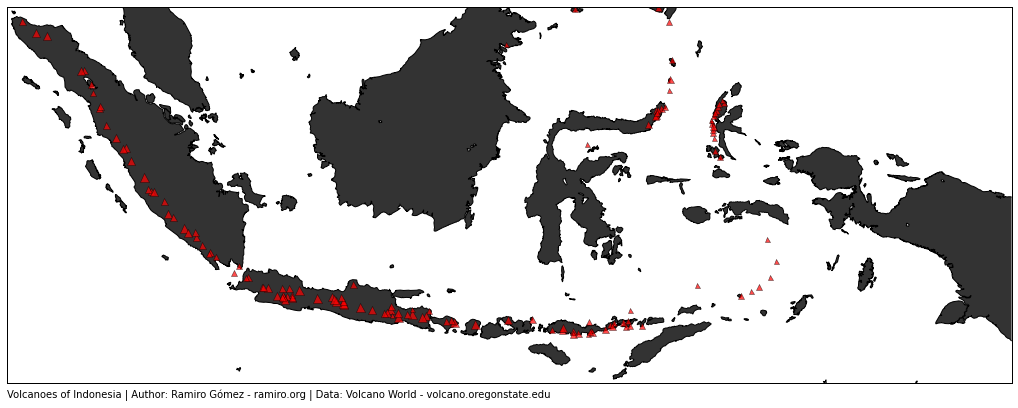

In [12]:
plt.figure(figsize=(18, 8))
plot_map(df_volc['Longitude'], df_volc['Latitude'], df_volc['Elevation (m)'],
         llcrnrlat=-11.1, urcrnrlat=6.1, llcrnrlon=95, urcrnrlon=141.1, min_marker_size=4)
plt.annotate('Volcanoes of Indonesia | ' + chartinfo, xy=(0, -1.04), xycoords='axes fraction')

## Volcanoes of the world

The final map shows all volcanoes in the data frame and the whole map using a background image obtained from the [NASA Web site](http://visibleearth.nasa.gov/view.php?id=73963). To be able to add this image to the map by calling the `warpimage` method, is why the `plot_map` function returns the Basemap object. Moreover, a title and an annotation are added with the code below.

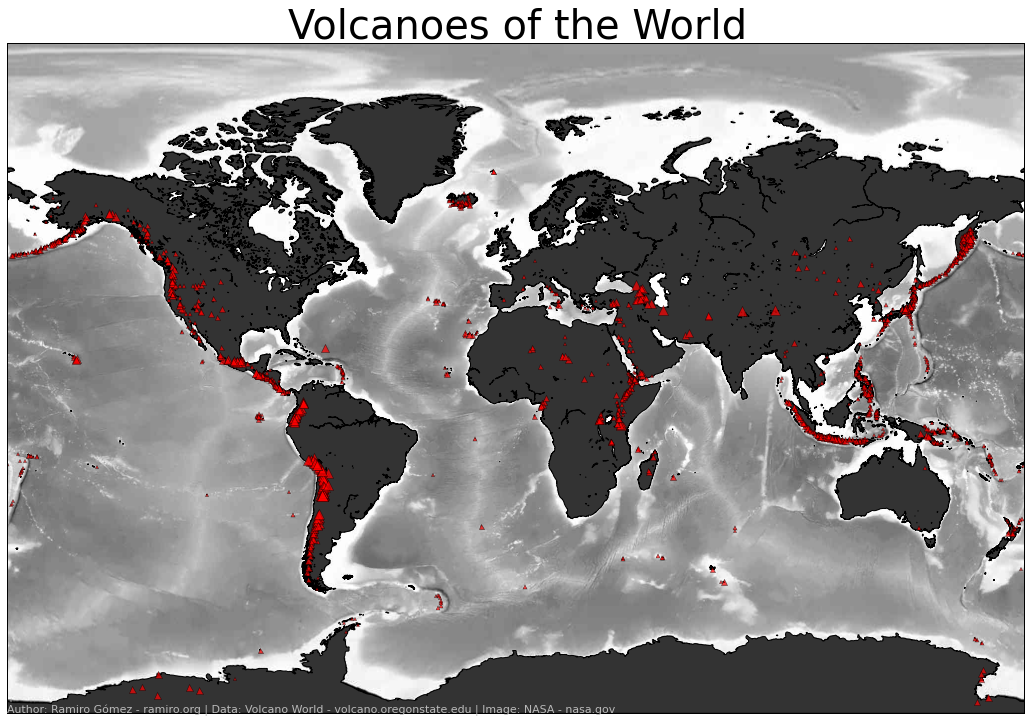

In [13]:
plt.figure(figsize=(20, 12))
m = plot_map(df_volc['Longitude'], df_volc['Latitude'], df_volc['Elevation (m)'], min_marker_size=2)
m.warpimage(image='img/raw-bathymetry.jpg', scale=1)

plt.title('Volcanoes of the World', color='#000000', fontsize=40)
plt.annotate(chartinfo + ' | Image: NASA - nasa.gov',
             (0, 0), color='#bbbbbb', fontsize=11)
plt.show()

## Map Poster

I also created a [poster of this map on Zazzle](http://www.zazzle.com/volcanoes_of_the_world_miller_projection_print-228575577731117978?rf=238355915198956003).

<a href="http://www.zazzle.com/volcanoes_of_the_world_miller_projection_print-228575577731117978?rf=238355915198956003"><img src="http://rlv.zcache.com/volcanoes_of_the_world_miller_projection_print-r61427a93ea4f4ce5b97c20d8afecc9c6_w2u_8byvr_500.jpg" alt="Volcanoes of the World - Miller Projection Print" /></a>

## Bonus: volcano globe

In addition to these static maps I created [this volcano globe](http://volcanoes.travel-channels.com/). It is built with the [WebGL globe](https://github.com/dataarts/webgl-globe) project, that expects the following data structure `[ latitude, longitude, magnitude, latitude, longitude, magnitude, ... ]`.

To achieve this structure, I create a data frame that contains only latitude, longitude, and elevation, call the `as_matrix` method which creates an array with a list of lists containing the column values, flatten this into a 1-dimensional array, turn it to a list and save the new data structure as a JSON file.

In [14]:
df_globe_values = df_volc[['Latitude', 'Longitude', 'Elevation (m)']]
globe_values = df_globe_values.as_matrix().flatten().tolist()
with open('json/globe_volcanoes.json', 'w') as f:
    json.dump(globe_values, f)

## Summary

This notebook shows how you can plot maps with locations using Pandas and Basemap. This was a rather quick walk-through, which did not go into too much detail explaining the code. If you like to learn more about the topic, I highly recommend the [Mapping Global Earthquake Activity](http://introtopython.org/visualization_earthquakes.html) tutorial, which is more in-depth and contains various nice examples. Have fun mapping data with Python!

In [15]:
%signature